In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
def create_x_y_selected_features(list_path, selected_features=None):
    """
    Phiên bản tối ưu: Sửa lỗi index float, cố định thứ tự band và tăng tốc độ xử lý.
    """
    if selected_features is None:
        selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

    # 1) Đọc CSV và gộp
    dfs = []
    print("[B1] Đọc CSV...")
    for p in tqdm(list_path, desc="Đọc file CSV"):
        # Mẹo: Xác định dtype ngay lúc đọc để tiết kiệm bộ nhớ nếu file lớn
        df = pd.read_csv(p)
        df["variable"] = df["variable"].astype(str)
        # Gán nhãn y
        df.loc[df["variable"].isin(['2019', '2020']), "variable"] = 'y'
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)

    # 2) Min/Max row/col → tạo hình chữ nhật
    min_row, max_row = df_all["row"].min(), df_all["row"].max()
    min_col, max_col = df_all["col"].min(), df_all["col"].max()
    n_row = int(max_row - min_row + 1)
    n_col = int(max_col - min_col + 1)

    # 3) Xác định danh sách band cần thiết (QUAN TRỌNG: Phải Sort để cố định thứ tự)
    required_bands_list = sorted(list(set(selected_features + ['y'])))
    required_bands_set = set(required_bands_list)
    print(f"-> Số lượng band bắt buộc: {len(required_bands_list)}")

    # 4) Lọc Timestamp hợp lệ (TỐI ƯU HÓA TỐC ĐỘ)
    print("[B2] Lọc timestamp đầy đủ (Vectorized Check)...")

    # Chỉ giữ lại các dòng thuộc các variable quan tâm để đếm cho nhanh
    df_check = df_all[df_all["variable"].isin(required_bands_set)]

    # Đếm số lượng variable unique trong mỗi timestamp
    # Nếu timestamp T1 có đủ 13 variable -> count sẽ là 13
    ts_counts = df_check.groupby("timestamp")["variable"].nunique()

    # Lấy ra các timestamp có số lượng variable bằng đúng số lượng yêu cầu
    valid_ts_index = ts_counts[ts_counts == len(required_bands_set)].index
    ts_valid = sorted(list(valid_ts_index))

    print(f"-> Tìm thấy {len(ts_valid)} timestamp hợp lệ.")

    # 5) Chuẩn bị dữ liệu để đổ vào Tensor
    print("[B3] Chuẩn bị index và Tensor...")

    # Tạo mapping index (Dictionary comprehension)
    t_to_idx = {t: i for i, t in enumerate(ts_valid)}
    b_to_idx = {b: i for i, b in enumerate(required_bands_list)} # Dùng list đã sort

    # Lọc dữ liệu chính thức:
    # - Chỉ lấy timestamp hợp lệ
    # - Chỉ lấy variable nằm trong required_bands (Bước này sửa lỗi Index Float)
    df_valid = df_all[
        (df_all["timestamp"].isin(ts_valid)) &
        (df_all["variable"].isin(required_bands_set))
    ].copy()

    # Map sang index (Ép kiểu int rõ ràng để tránh lỗi)
    df_valid["t_idx"] = df_valid["timestamp"].map(t_to_idx).astype(int)
    df_valid["b_idx"] = df_valid["variable"].map(b_to_idx).astype(int)
    df_valid["r_idx"] = (df_valid["row"] - min_row).astype(int)
    df_valid["c_idx"] = (df_valid["col"] - min_col).astype(int)

    # 6) Đổ dữ liệu vào Tensor (Vectorized - Không cần vòng lặp)
    print("[B4] Đổ dữ liệu vào Tensor...")
    tensor = np.zeros((len(ts_valid), len(required_bands_list), n_row, n_col), dtype=float)

    # Numpy Advanced Indexing: Nhanh hơn loop rất nhiều
    tensor[df_valid["t_idx"].values,
           df_valid["b_idx"].values,
           df_valid["r_idx"].values,
           df_valid["c_idx"].values] = df_valid["value"].values

    # 7) Tách X và y
    y_idx = b_to_idx['y']
    # Lấy mảng X indices: loại bỏ index của y
    x_indices = [i for i, b in enumerate(required_bands_list) if b != 'y']

    # Slice tensor
    # Y shape: (timestamp, 1, row, col) -> thường người ta để (timestamp, row, col) thì dùng squeeze
    # Nhưng theo code cũ bạn để nguyên dim channel nên mình giữ nguyên
    y = tensor[:, [y_idx], :, :]
    x = tensor[:, x_indices, :, :]

    return x, y, ts_valid, required_bands_list, (min_row, max_row), (min_col, max_col)

In [5]:
def luuTensor():
    list_file = [
        'csv_data/HIMA_hatinh.csv',
        'csv_data/ERA5_hatinh.csv',
        'csv_data/RADAR_hatinh.csv'
    ]

    x, y, timestamps, x_bands, row_range, col_range = create_x_y_selected_features(list_file)

    print("[B4] Lưu tensor...")
    np.save("csv_data/x_hatinh.npy", x)
    np.save('csv_data/y_hatinh.npy', np.squeeze(y, axis=1))

    print("X shape:", x.shape)
    print("Y shape:", y.shape)
luuTensor()

[B1] Đọc CSV...


Đọc file CSV: 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


-> Số lượng band bắt buộc: 13
[B2] Lọc timestamp đầy đủ (Vectorized Check)...
-> Tìm thấy 1223 timestamp hợp lệ.
[B3] Chuẩn bị index và Tensor...
[B4] Đổ dữ liệu vào Tensor...
[B4] Lưu tensor...
X shape: (1223, 12, 21, 34)
Y shape: (1223, 1, 21, 34)


In [8]:
xHaTinh = np.load("csv_data/x_hatinh.npy")
yHaTinh = np.load("csv_data/y_hatinh.npy")
print('X đầy đủ',xHaTinh.shape)
print('y đầy đủ',yHaTinh.shape)

X đầy đủ (1223, 12, 21, 34)
y đầy đủ (1223, 21, 34)


In [9]:
# Loại bỏ chiều thứ 2 và lưu file mới
np.save('csv_data/y_hatinh_new.npy', np.squeeze(yHaTinh, axis=1))

# Kiểm tra kết quả
y_new = np.load('csv_data/y_hatinh_new.npy')
print(f"Shape mới: {y_new.shape}")

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 2. Thống kê số lượng số 0
total_pixels = yHaTinh.size                  # Tổng số điểm dữ liệu (Time x Row x Col)
zero_pixels = np.sum(yHaTinh == 0)           # Số lượng điểm bằng 0 tuyệt đối
near_zero_pixels = np.sum(yHaTinh < 0.1)     # Số lượng điểm rất nhỏ (gần như 0)

percent_zeros = (zero_pixels / total_pixels) * 100

print(f"{'='*40}")
print(f"BÁO CÁO DỮ LIỆU Y (Mưa)")
print(f"{'='*40}")
print(f"1. Kích thước (Shape): {yHaTinh.shape}")
print(f"2. Tổng số pixel:      {total_pixels:,}")
print(f"3. Số lượng giá trị 0: {zero_pixels:,}")
print(f"4. Tỷ lệ số 0:         {percent_zeros:.2f}%")
print(f"5. Giá trị lớn nhất:   {yHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất:   {yHaTinh.min()}")
print(f"{'='*40}")


BÁO CÁO DỮ LIỆU Y (Mưa)
1. Kích thước (Shape): (1223, 1, 21, 34)
2. Tổng số pixel:      873,222
3. Số lượng giá trị 0: 803,761
4. Tỷ lệ số 0:         92.05%
5. Giá trị lớn nhất:   260.0
6. Giá trị nhỏ nhất:   0.0


Shape dùng để vẽ bản đồ: (21, 34)


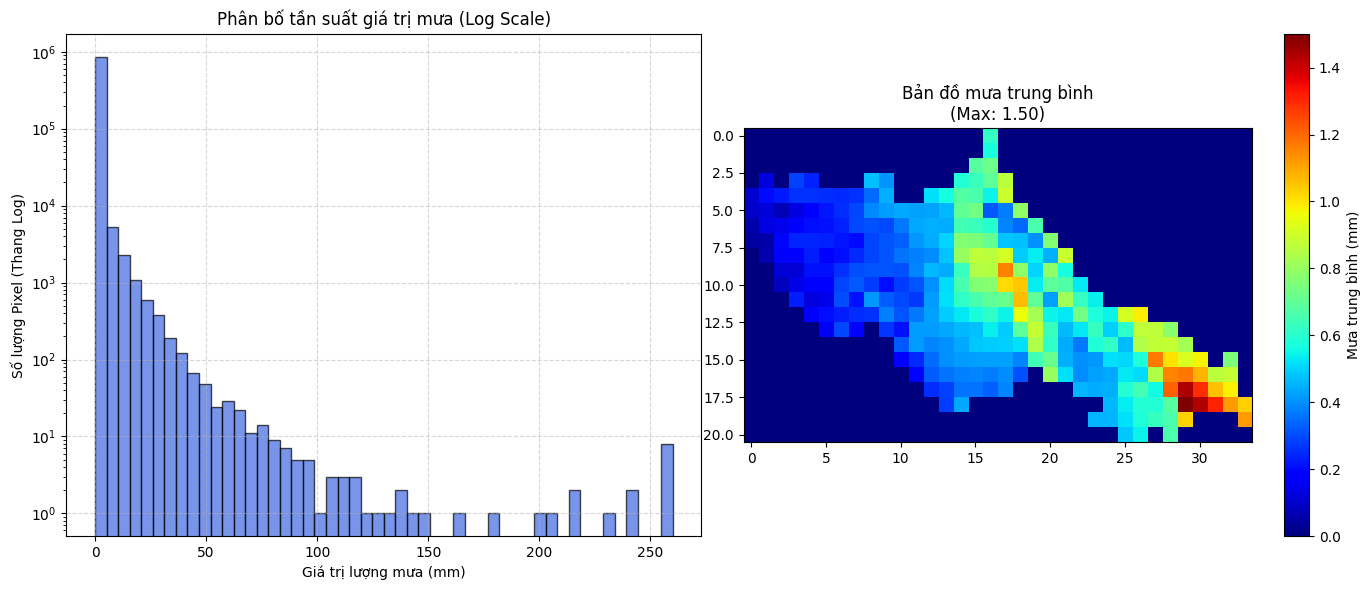

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã load yHaTinh rồi
# yHaTinh = np.load("csv_data/y_hatinh.npy")

# --- BƯỚC 1: TÍNH TOÁN VÀ XỬ LÝ SHAPE ---
# Tính trung bình theo thời gian (axis=0)
mean_rain = np.mean(yHaTinh, axis=0)

# QUAN TRỌNG: Dùng .squeeze() để loại bỏ các chiều có kích thước = 1
# Ví dụ: Biến shape (1, 21, 34) thành (21, 34) để imshow vẽ được
mean_rain = mean_rain.squeeze()

print(f"Shape dùng để vẽ bản đồ: {mean_rain.shape}")
# Nếu in ra (21, 34) là chuẩn. Nếu ra (1, 21, 34) là lỗi.

# --- BƯỚC 2: VẼ BIỂU ĐỒ ---
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Histogram (Phân bố giá trị)
plt.subplot(1, 2, 1)
# flatten() để duỗi thẳng dữ liệu ra đếm cho dễ
plt.hist(yHaTinh.flatten(), bins=50, log=True, color='royalblue', edgecolor='black', alpha=0.7)
plt.title("Phân bố tần suất giá trị mưa (Log Scale)")
plt.xlabel("Giá trị lượng mưa (mm)")
plt.ylabel("Số lượng Pixel (Thang Log)")
plt.grid(True, linestyle='--', alpha=0.5)

# Biểu đồ 2: Bản đồ nhiệt (Heatmap)
plt.subplot(1, 2, 2)
# cmap='jet' (xanh->đỏ) hoặc 'Blues' (trắng->xanh đậm) tùy bạn thích
im = plt.imshow(mean_rain, cmap='jet', interpolation='nearest')
plt.colorbar(im, label='Mưa trung bình (mm)')
plt.title(f"Bản đồ mưa trung bình\n(Max: {mean_rain.max():.2f})")

plt.tight_layout()
plt.show()